# Part3&4_Assignment 7.1 Time-Series Stationarity Diagnostics & Forecasting Techniques

## Data Preparation

In [1]:
!pip install statsmodels

   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ------- -------------------------------- 1.8/9.8 MB 9.1 MB/s eta 0:00:01
   -------- ------------------------------- 2.1/9.8 MB 9.0 MB/s eta 0:00:01
   -------- ------------------------------- 2.1/9.8 MB 9.0 MB/s eta 0:00:01
   -------- ------------------------------- 2.1/9.8 MB 9.0 MB/s eta 0:00:01
   --------- ------------------------------ 2.4/9.8 MB 2.1 MB/s eta 0:00:04
   ------------ --------------------------- 3.1/9.8 MB 2.7 MB/s eta 0:00:03
   ----------------- ---------------------- 4.2/9.8 MB 2.8 MB/s eta 0:00:02
   --------------------- ------------------ 5.2/9.8 MB 3.1 MB/s eta 0:00:02
   ----------------------- ---------------- 5.8/9.8 MB 3.1 MB/s eta 0:00:02
   ------------------------- -------------- 6.3/9.8 MB 3.2 MB/s eta 0:00:02
   ----------------------------- ---------- 7.3/9.8 MB 3.3 MB/s eta 0:00:01
   ---------------------------------- ----- 8.4/9.8 MB 3.4 MB/s eta 0:00:01
   ----------------

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import scipy
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("stealthtechnologies/traffic-time-series-dataset")

print("Path to dataset files:", path)

100%|██████████| 47.3k/47.3k [00:00<00:00, 470kB/s]

Extracting files...
Path to dataset files: C:\Users\Ery\.cache\kagglehub\datasets\stealthtechnologies\traffic-time-series-dataset\versions\1


In [9]:
ts = pd.read_csv('datasets/traffic_dataset_with_trend.csv', parse_dates=['Timestamp'],index_col='Timestamp')

In [11]:
ts.head()

,Weather,Events,Traffic Volume
Timestamp,,,
2023-01-01 00:00:00,Cloudy,False,803.0
2023-01-01 01:00:00,Clear,False,861.0
2023-01-01 02:00:00,Clear,False,582.0
2023-01-01 03:00:00,Cloudy,False,236.0
2023-01-01 04:00:00,Cloudy,False,569.0


In [13]:
ts.drop(['Weather','Events'],axis=1,inplace=True) # making the dataset univariate

In [15]:
ts.head()

,Traffic Volume
Timestamp,
2023-01-01 00:00:00,803.0
2023-01-01 01:00:00,861.0
2023-01-01 02:00:00,582.0
2023-01-01 03:00:00,236.0
2023-01-01 04:00:00,569.0


In [17]:
ts.sort_index(inplace=True)

In [19]:
ts = ts.asfreq(pd.infer_freq(ts.index))

In [21]:
ts.shape

(8736, 1)

In [23]:
ts.head()

,Traffic Volume
Timestamp,
2023-01-01 00:00:00,803.0
2023-01-01 01:00:00,861.0
2023-01-01 02:00:00,582.0
2023-01-01 03:00:00,236.0
2023-01-01 04:00:00,569.0


In [25]:
ts.index.is_monotonic_increasing

True

In [27]:
ts.index.freq

<Hour>

In [29]:
scaler = StandardScaler()
ts_scaled = scaler.fit_transform(ts[['Traffic Volume']])

ts.drop(['Traffic Volume'], axis =1, inplace=True)
ts['Traffic Volume'] = ts_scaled

In [31]:
ts.head()

,Traffic Volume
Timestamp,
2023-01-01 00:00:00,-0.657815
2023-01-01 01:00:00,-0.578062
2023-01-01 02:00:00,-0.961700
2023-01-01 03:00:00,-1.437465
2023-01-01 04:00:00,-0.979575


In [33]:
train_size = int(len(ts) * 0.8)
train, test = ts.iloc[:train_size], ts.iloc[train_size:]

In [35]:
train.shape

(6988, 1)

In [37]:
test.shape

(1748, 1)

In [39]:
type(ts.index)

pandas.core.indexes.datetimes.DatetimeIndex

## Part 3: Exponential Smoothing Family

In [41]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import mean_squared_error as mse

### SimpleExpSmoothing

In [43]:
ses_model = SimpleExpSmoothing(train).fit()
ses_forecast = ses_model.forecast(len(test))

mse_ses = mse(test, ses_forecast)

In [45]:
print("Simple Exponential Smoothing MSE:", mse_ses)

Simple Exponential Smoothing MSE: 1.0199213897496802


### Holt

In [49]:
holt_model = Holt(train).fit()
holt_forecast = holt_model.forecast(len(test))

mse_holt = mse(test, holt_forecast)

In [51]:
print("Holt MSE:", mse_holt)

Holt MSE: 1.4779050374714149


### ExponentialSmoothing

In [53]:
es_model = ExponentialSmoothing(train, trend='add', seasonal='add').fit()
es_forecast = es_model.forecast(len(test))

mse_es = mse(test, es_forecast)

In [55]:
print("Exponential Smoothing MSE:", mse_es)

Exponential Smoothing MSE: 0.9725145532140564


I'll be using exponential smoothing variant since it produced the lowest mse score

## Part 4: ACF/PACF Diagnostics & Seasonal Models

### Plot ACF & PAC

In [57]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

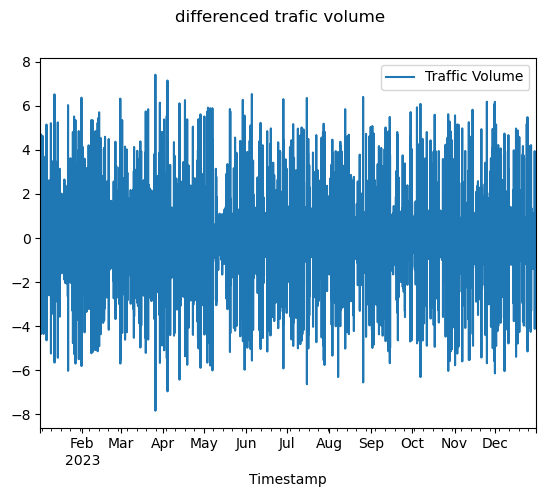

In [69]:
ts.diff().dropna().plot()
plt.suptitle('differenced trafic volume')
plt.show()

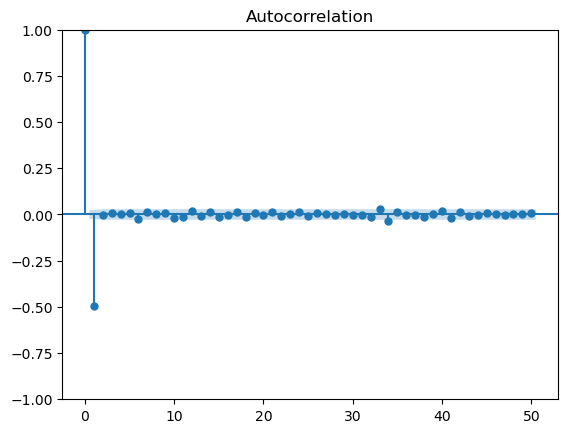

In [71]:
plot_acf(train.diff().dropna(),lags=50)
plt.show()

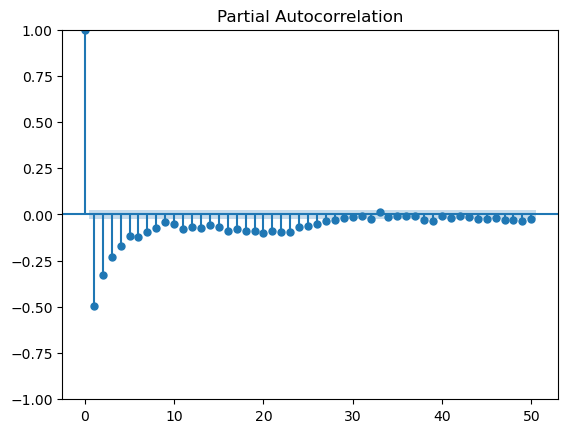

In [75]:
plot_pacf(train.diff().dropna(), lags=50, method='ywm')
plt.show()

### Building AR,ARIMA,SARIMA Models

#### ARIMA-p

In [82]:
# model ar
p = 2
ar_model = ARIMA(train, order=(p,0,0)).fit()
ar_forecast = ar_model.forecast(len(test))
mse_ar = mse(test, ar_forecast)

In [84]:
print('ARIMA model MSE:', mse_ar)

ARIMA model MSE: 1.0172512397077191


#### ARIMA-p,d,q

In [89]:
p,d,q = 2,1,2
arima2_model = ARIMA(train,order=(p,d,q)).fit()
arima2_forecast = arima2_model.forecast(len(test))
arima2_mse = mse(test,arima2_forecast)

In [91]:
print('ARIMA-p,d,q mode MSE:', arima2_mse)

ARIMA-p,d,q mode MSE: 1.018244003792586


#### SARIMA

In [94]:
sarima_model = SARIMAX(train, order=(p,d,q), seasonal_order=(1,1,1,24)).fit()
sarima_forecast = sarima_model.forecast(len(test))
sarima_mse = mse(test, sarima_forecast)

E:\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [95]:
print('SARIMA model MSE:', sarima_mse)

SARIMA model MSE: 0.9719771576375598


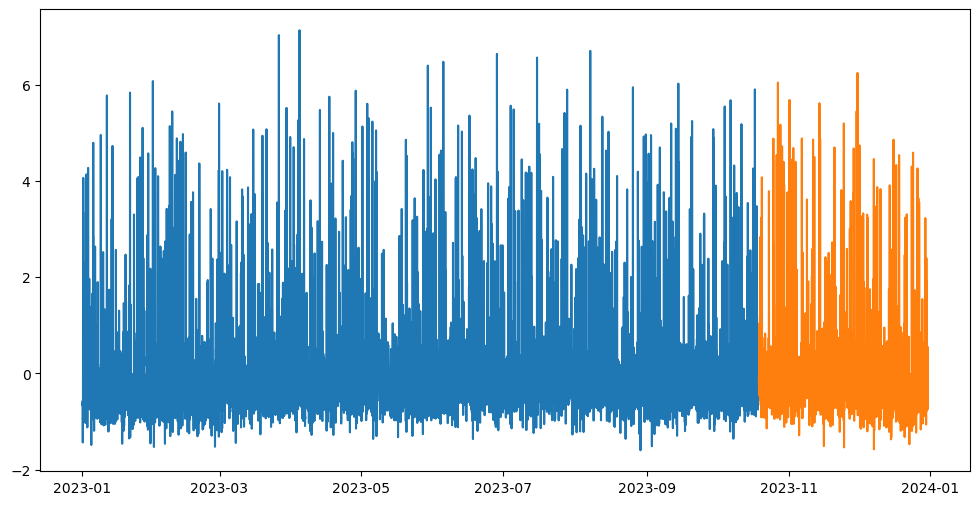

In [110]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.show()

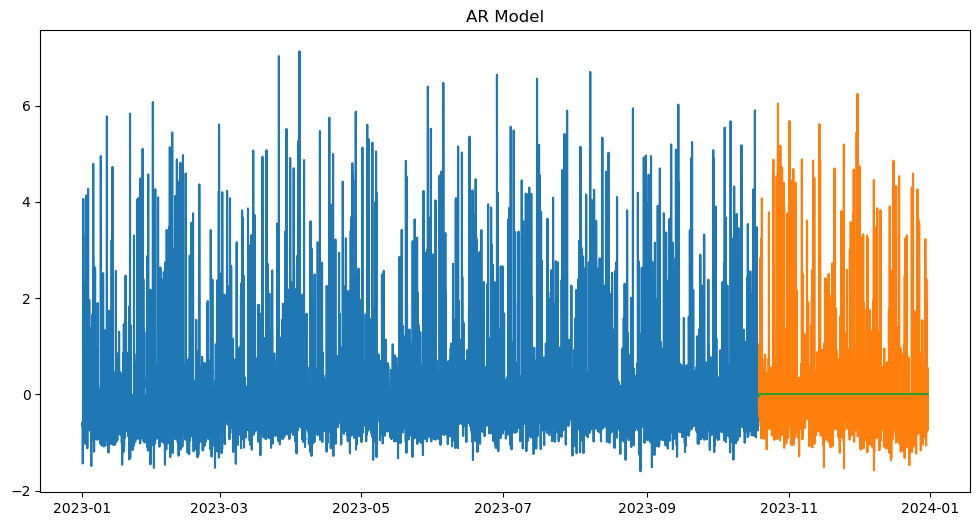

In [118]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, ar_forecast, label='AR Forecast')
plt.title('AR Model')
plt.show()

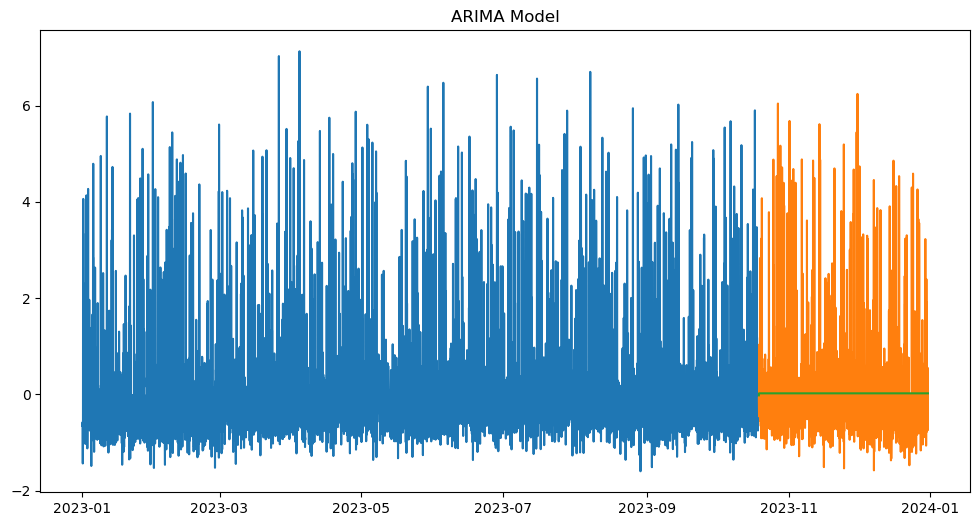

In [120]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, arima2_forecast, label='AR Forecast')
plt.title('ARIMA Model')
plt.show()

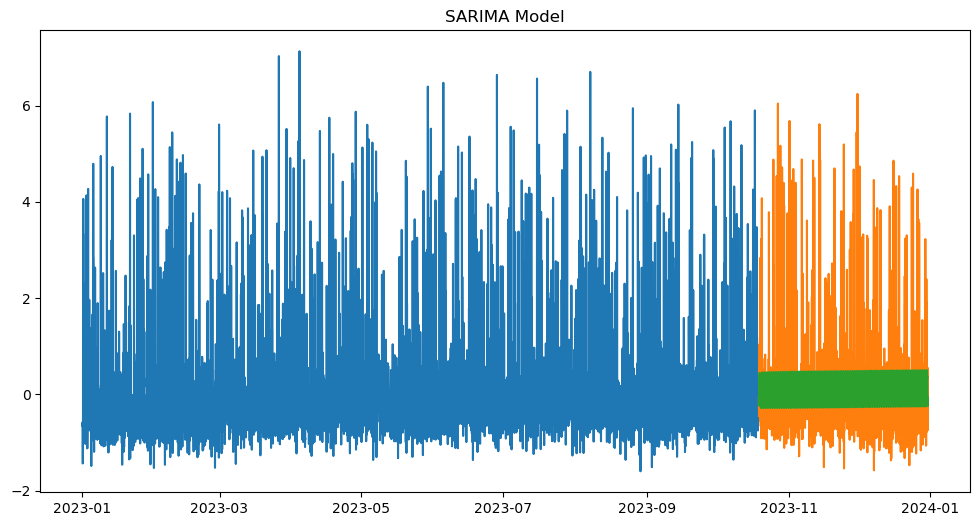

In [122]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, sarima_forecast, label='AR Forecast')
plt.title('SARIMA Model')
plt.show()

In [134]:
results = pd.DataFrame({
    'Model': ['AR', 'ARIMA', 'SARIMA'],
    'Test MSE': [mse_ar, arima2_mse, sarima_mse],
    'Train AIC': [ar_model.aic, arima2_model.aic, sarima_model.aic]
})

print(results)

    Model  Test MSE     Train AIC
0      AR  1.017251  19730.383243
1   ARIMA  1.018244  19751.324020
2  SARIMA  0.971977  19413.519691


The preferred model is SARIMA Model because it produced the lowest AIC